In [2]:
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np
import copy
import cv2

(1632, 1080, 4)


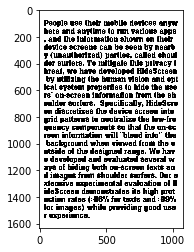

文本大小 691792
图片大小： 1762560
占比 0.3925


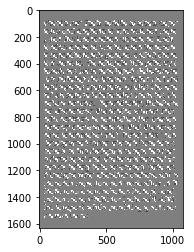

(605, 780, 3)


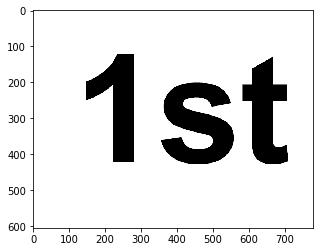

文本大小 72528
图片大小： 471900
占比 0.1537


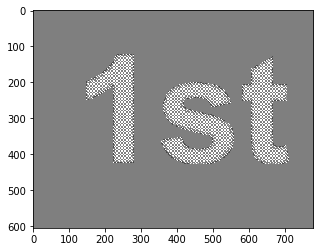

(461, 1017, 3)


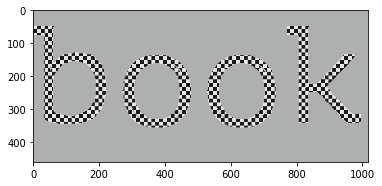

文本大小 81692
图片大小： 468837
占比 0.1742


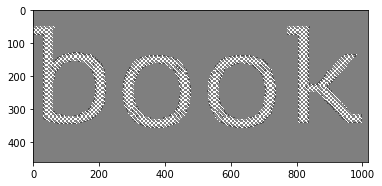

(168, 207, 3)


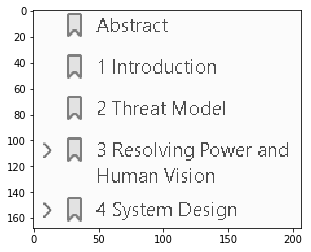

文本大小 4732
图片大小： 34776
占比 0.1361


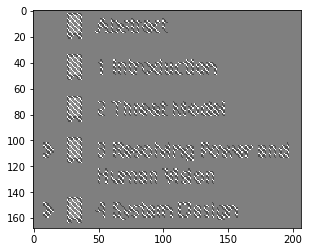

In [3]:
grid_height=2
grid_width=2
num_picture=4  # 图片个数
num_level=3    # 边界层数

# 8个方向
dx = np.array([-grid_height,-grid_height,-grid_height,0,0,grid_height,grid_height,grid_height])
dy = np.array([-grid_width,0,grid_width,-grid_width,grid_width,-grid_width,0,grid_width])

def check_boundary(x,y,b): # 检测是否是第b类边界
        if boundary_layer[x][y]<b: # 这个格子是背景色或第1、...、b-1类边界
            return 0                # 不是第b类边界
        for i in range(8):
            nextx=x+dx[i]
            nexty=y+dy[i]
            if nextx<0 or nextx>=h or nexty<0 or nexty>=w:
                continue
            if boundary_layer[nextx][nexty]<b:
                return 1
        return 0 # 周围都是4（num_level+1, 内部区域）


for ith in range(0,num_picture):
    data = mpimg.imread('pictures/HidenText/'+str(ith)+'.png')

    h=data.shape[0] # 高度
    w=data.shape[1] # 宽度
    print(data.shape)
    if data.shape[2]==4:
        data=data[:,:,0:3]
    data*=255.0
    data = data.astype(np.uint8)
    plt.imshow(data) # 显示图片
    plt.axis('on') 
    plt.show()

    Hbgr=data[0][0][0]  # original background color
    Hbgg=data[0][0][1]
    Hbgb=data[0][0][2]
    
    Hbright_R=255
    Hbright_G=255
    Hbright_B=255
    
    # 把背景变成背景色，文本变成白色（全255）
    for i in range(0,h):
        for j in range(0,w):
            if data[i][j][0]==Hbgr and data[i][j][1]==Hbgg and data[i][j][2]==Hbgb: # 背景换色
                data[i][j][0]=127 #Hbgr
                data[i][j][1]=127 #Hbgg
                data[i][j][2]=127 #Hbgb
            else: # 文本换色
                data[i][j][0]=Hbright_R
                data[i][j][1]=Hbright_G
                data[i][j][2]=Hbright_B
    
    Hbgr=127
    Hbgg=127
    Hbgb=127
    
    num_text=0
    
    # 0代表是背景颜色，1代表第1层边界，2代表第2层边界，3代表第3层边界，4代表文本内部
    # 只对网格的第一个点赋值，代表整个网格的类比
    boundary_layer=np.zeros((h,w)) 
    
    # 找出文本内部（非背景区域）
    for i in range(0,h,grid_height):
        for j in range(0,w,grid_width): # 求ij格子内是否有文本
            not_background=0
            for ii in range(i,min(h,i+grid_height)):
                for jj in range(j,min(w,j+grid_width)):
                    if data[ii][jj][0]!=Hbgr or data[ii][jj][1]!=Hbgg or data[ii][jj][2]!=Hbgb:
                        not_background=1
                        break
                if not_background:
                    break
            if not_background: # 当前格子不全是背景颜色
                boundary_layer[i][j]=num_level+1 
                num_text+=1
                # 文本内部转换成相间颜色
                if (i/grid_height+j/grid_width)%2==1:
                    for ii in range(i,min(h,i+grid_height)):
                        for jj in range(j,min(w,j+grid_width)):
                            data[ii][jj][0]=Hbgr
                            data[ii][jj][1]=Hbgg
                            data[ii][jj][2]=Hbgb
                else:  # 本来就是亮色了，除非是边界，但边界后面会重新赋值
                    for ii in range(i,min(h,i+grid_height)):
                        for jj in range(j,min(w,j+grid_width)):
                            data[ii][jj][0]=Hbright_R
                            data[ii][jj][1]=Hbright_G
                            data[ii][jj][2]=Hbright_B
    
    print('文本大小',num_text*grid_height*grid_width)
    print('图片大小：',h*w)
    print('占比',round(num_text*grid_height*grid_width/h/w,4))
    
    for level in range(1,num_level+1):
        for i in range(0,h,grid_height):
            for j in range(0,w,grid_width): # 求ij的边界类型123
                if check_boundary(i,j,level):
                    boundary_layer[i][j]=level
                    if (i/grid_height+j/grid_width)%2==1:
                        #   正对角线
                        
                        data[i][j][0]=(Hbgr+(-1)**level*(num_level-level)*Hbright_R/10+256)%256
                        data[i][j][1]=(Hbgg+(-1)**level*(num_level-level)*Hbright_G/10+256)%256
                        data[i][j][2]=(Hbgb+(-1)**level*(num_level-level)*Hbright_B/10+256)%256

                        data[i+1][j+1][0]=(Hbgr+(-1)**level*(num_level-level)*Hbright_R/10+256)%256
                        data[i+1][j+1][1]=(Hbgg+(-1)**level*(num_level-level)*Hbright_G/10+256)%256
                        data[i+1][j+1][2]=(Hbgb+(-1)**level*(num_level-level)*Hbright_B/10+256)%256
                    else:
                        #   斜对角线
                        
                        data[i+1][j][0]=(Hbgr+(-1)**level*(num_level-level)*Hbright_R/10+256)%256
                        data[i+1][j][1]=(Hbgg+(-1)**level*(num_level-level)*Hbright_G/10+256)%256
                        data[i+1][j][2]=(Hbgb+(-1)**level*(num_level-level)*Hbright_B/10+256)%256
                        
                        data[i][j+1][0]=(Hbgr+(-1)**level*(num_level-level)*Hbright_R/10+256)%256
                        data[i][j+1][1]=(Hbgg+(-1)**level*(num_level-level)*Hbright_G/10+256)%256
                        data[i][j+1][2]=(Hbgb+(-1)**level*(num_level-level)*Hbright_B/10+256)%256
#                     #格子里所有像素都换色
#                     for ii in range(i,min(h,i+grid_height)): 
#                         for jj in range(j,min(w,j+grid_width)): 
#                             data[ii][jj][0]=(Hbgr+(-1)**level*(num_level-level)*Hbright_R/10+256)%256
#                             data[ii][jj][1]=(Hbgg+(-1)**level*(num_level-level)*Hbright_G/10+256)%256
#                             data[ii][jj][2]=(Hbgb+(-1)**level*(num_level-level)*Hbright_B/10+256)%256

    plt.imshow(data) # 显示图片
    plt.axis('on') 
    plt.show()

(461, 1017, 3)


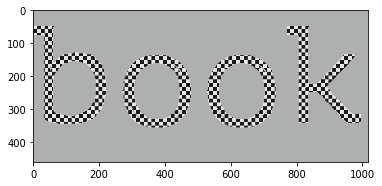

173


In [159]:

# a=copy.deepcopy(data)

data = mpimg.imread('pictures/'+str(2)+'.png')

h=data.shape[0] # 高度
w=data.shape[1] # 宽度
print(data.shape)

data*=255.0
data = data.astype(np.uint8)
plt.imshow(data) # 显示图片
plt.axis('on') 
plt.show()

Hbgr=data[0][0][0]  # original background color
Hbgg=data[0][0][1]
Hbgb=data[0][0][2]
print(Hbgr)

In [30]:
grid_height=1
grid_width=1
num_picture=4  # 图片个数
num_level=3    # 边界层数

# 8个方向
dx = np.array([-grid_height,-grid_height,-grid_height,0,0,grid_height,grid_height,grid_height])
dy = np.array([-grid_width,0,grid_width,-grid_width,grid_width,-grid_width,0,grid_width])

def check_boundary(x,y,b): # 检测是否是第b类边界
        if boundary_layer[x][y]<b: # 这个格子是背景色或第1、...、b-1类边界
            return 0                # 不是第b类边界
        for i in range(8):
            nextx=x+dx[i]
            nexty=y+dy[i]
            if nextx<0 or nextx>=h or nexty<0 or nexty>=w:
                continue
            if boundary_layer[nextx][nexty]<b:
                return 1
        return 0 # 周围都是4（num_level+1, 内部区域）

# 换了种读取图片的方式：cv2
for ith in range(2,num_picture-1):
    
    img = cv2.imread('pictures/HidenText/'+str(ith)+'.png')#,cv2.IMREAD_GRAYSCALE)
    data = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    cv2.imshow('Test',data)
    cv2.waitKey()

    h=data.shape[0] # 高度
    w=data.shape[1] # 宽度
    print(data.shape)  

    old_Hbg=data[0][0]
    print(old_Hbg)
    Hbg=old_Hbg
    Hbright=255
    
#     # 把背景变成背景色，文本变成白色（全255）
#     for i in range(0,h):
#         for j in range(0,w):
#             if data[i][j]==old_Hbg: # 背景换色
#                 data[i][j]=Hbg
#             else:
#                 data[i][j]=Hbright
                
    num_text=0
    
    # 0代表是背景颜色，1代表第1层边界，2代表第2层边界，3代表第3层边界，4代表文本内部
    # 只对网格的第一个点赋值，代表整个网格的类比
    boundary_layer=np.zeros((h,w)) 
    
    # 找出文本内部（非背景区域）
    for i in range(0,h,grid_height):
        for j in range(0,w,grid_width): # 求ij格子内是否有文本
            not_background=0
            for ii in range(i,min(h,i+grid_height)):
                for jj in range(j,min(w,j+grid_width)):
                    if data[ii][jj]!=Hbg:
                        not_background=1
                        break
                if not_background:
                    break
            if not_background:
                boundary_layer[i][j]=num_level+1 # 当前格子不全是背景颜色
                num_text+=1
#                 # 文本内部转换成相间颜色
#                 if (i/grid_height+j/grid_width)%2==1:
#                     for ii in range(i,min(h,i+grid_height)):
#                         for jj in range(j,min(w,j+grid_width)):
#                             data[ii][jj]=Hbg
#                 else:  # 本来就是亮色了，除非是边界，但边界后面会重新赋值
#                     for ii in range(i,min(h,i+grid_height)):
#                         for jj in range(j,min(w,j+grid_width)):
#                             data[ii][jj]=0#Hbright
    
    print('文本大小',num_text*grid_height*grid_width)
    print('图片大小：',h*w)
    print('占比',round(num_text*grid_height*grid_width/h/w,4))
    
    for level in range(1,num_level+1):
        for i in range(0,h,grid_height):
            for j in range(0,w,grid_width): # 求ij的边界类型123
                if check_boundary(i,j,level):
                    boundary_layer[i][j]=level
#                     if (i/grid_height+j/grid_width)%2==1:
# #                         #   正对角线
#                         data[i][j]=(Hbg+(-1)**level*(num_level-level)*Hbright/10+256)%256
#                         data[i+1][j+1]=(Hbg+(-1)**level*(num_level-level)*Hbright/10+256)%256
#                     else:
# #                         #   斜对角线
#                         data[i+1][j]=(Hbg+(-1)**level*(num_level-level)*Hbright/10+256)%256
#                         data[i][j+1]=(Hbg+(-1)**level*(num_level-level)*Hbright/10+256)%256

                    #格子里所有像素都换色
                    for ii in range(i,min(h,i+grid_height)): 
                        for jj in range(j,min(w,j+grid_width)): 
                            data[ii][jj]=(Hbg+(-1)**level*(num_level-level)*Hbright/6+256)%256

#     cv2.imshow('Test',data)
#     cv2.waitKey()
    cv2.imwrite('ReproductionImages/HidenText/8(b)p3.png', data)

(461, 1017)
175
文本大小 78010
图片大小： 468837
占比 0.1664


In [5]:
img = cv2.imread('pictures/HidenText/'+str(0)+'.png')#,cv2.IMREAD_GRAYSCALE)
data = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
cv2.imshow('Test',data)
cv2.waitKey()

-1

In [35]:
print(data.shape)
print(np.sum(data==234))

(1632, 1080)
108
